# A computer simulation of particle mitigation using a magnetic field
Created by Ricky Teunissen  
ASML group 16

last time updated: 13/01/2022

## General info
The code in this file can be run to simulate particle trajectories particles with given properties in a superposition of force field would experience.
Within this model, it has been chosen to place the reticle as a plane located at RETICLE_Z = 0.31 m.

The code works by dividing the particles trajectorie in smaller section. At the end of every small timestep, newtons law is used to calculate the new velocity and position of the particle. This is doning using the runga-kutta method. In every simulation the particle starts at (0.0,0,0) and the simulation runs either till the particle has reached RETICLE_Z  or after 1e4 iterations (to prevent the code from getting stuck in a loop)

__Some limitations of the models__:
- The code in this file is not capable of calculating a change in flow by adding a magnet.
- The code in this file assumes (time averaged) constant force fields. It does not work with particle-particle collisions. This is probably however not a problem since the contamination particles are large and it is hence a fine approximation to use a drag force (which is time averaged) as a replacement for the particle-particle collision.
- All forcefields are simplifications of reality

__NOTE__:
The actual electric, flow, etc. fields within the used ASML machine are very complicated. We are never going to be able to understand and/or implement them. Instead this code should be used as a proof of concept, making it easyr to quickly see what multiple forces do. (This is probably also all we can do in these 10 weeks)

__Coordinate system__:
y goes __into__ the plane, x "to the right" and z "up"


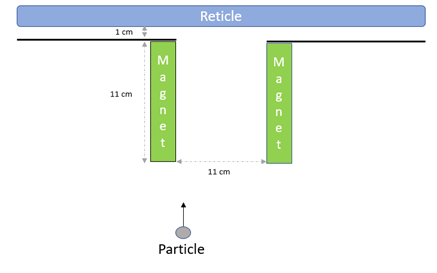

In [58]:
# the next line ensures that the plots appear within the notebook, the 2nd line ensure that the plot appears in a separate 
# window s.t. it can be rotated and saved, uncomment the preffered one:
# %matplotlib inline
%matplotlib qt

import numpy as np
import matplotlib.pyplot as plt
from scipy import constants

## Parameters to control/ particle properties

In [69]:
TIMESTEP = 1e-4 # seconds
RETICLE_Z = 0.31  #m
PARTICLE_DENSITY = 4e3 #kg/m3 = density of water/metal-ish


#constants
eps0 = constants.value('vacuum electric permittivity')
elementary_charge = constants.value('elementary charge')

In [60]:
def calc_mass(radius: float):
    """
    Returns the mass of the particle of a given radius. Assumes spherical particles with density PARTICLE_DENSITY 
    """
    mass = 4/3 * np.pi * (radius)**3 * PARTICLE_DENSITY
    return mass

In [61]:
def calc_charge(radius: float):
    """
    Returns the charge of the particle in the plasma depending on its radius. 
    Here we make use of a  simplified charge model: the charge is linear with the radius, but we found that the 
    charge for a particle with a radius of 5 um is 1e4 e so we can relate this to the particle of our radius.
    
    """
    
    charge_10um = -1e4*elementary_charge
    charge_r = radius/(5e-6)*charge_10um  # compare to radius of 5e-6 and use fact that charge scales linearly
    
    return charge_r
    

## Force fields of interest
This Section will be used to define the several force fields inside of the software. Every function is defined such that one only has to give the particle position and maybe some other quantities. The functions then return the strenght of the force working on the particle given this field.

In [62]:
def magnetic_field_force(pos, vel, charge: float, magnet_length:float = 0.3, field_strength: float = 1):
    """
    This function will hold all of the information about the magnetic force field. For now the force field is defined as 
    a homogeneous magnetic force field in the y- direction (into the plane). In reality the B-field will "leak out" of the 
    area enclosed by the magnets, but for simplicity we don't consider this for now. Later, this can probably be added.
    
    This means that the magnetic field is present between RETTICLE_Z-0.01-magnet_length and RETTICLE_Z-0.01. 
    
    The charge is the charge of the particle.
    
    The magnetic length is not yet included in any other code: it is just kept at the default.
    """
    
    B_field = np.array([0,field_strength,0])
    
    # Only B-field between the magnets
    if (RETICLE_Z - 0.01 - magnet_length) < pos[2] < (RETICLE_Z -0.01) :
        
        # F = q v x B
        Bforce = charge * np.cross(vel, B_field)
        
    else:
        Bforce = np.array([0,0,0])
        
    return Bforce


In [63]:
def retticle_attraction_force(pos: np.array, charge_particle: float):
    """
    This function will hold all of the information about the retticle attraction force field.
    
    We for now neglect pariticle E-field and assume an E-field as generated by an infinite plate, but screening of the
    plasma is taken into account. (see literature)
    
    """
    
    debye_schielding = 0.0005  # typically 0.5 mm but can reach 20 mm outside laser area
    E_at_retticle = 1e5        # V/m, worst case scenario assuming 40V in reality 20 times smaller
    
    distance_reticle = abs(RETICLE_Z- pos[2])
   
    # Reticle is positvely charged, we look at region below reticle so E-field in negative z-dir (away reticle)
    strenght_E = E_at_retticle * np.exp(-distance_reticle/debye_schielding)
    E_field = np.array([0,0, -strenght_E])
    Eforce = charge_particle*E_field
    
    return Eforce


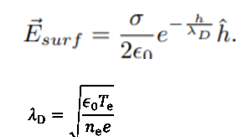

In [70]:
def drag_force(pos: np.array, vel: np.array, radius: float)-> np.array:
    """
    This function will return the drag force working on the particle.
    For simplicity,do we assume that only 2 different homogeneous flow direction exist (see image).
    We assume that the magnitude of the drag force in the upper channel is much higher than in the lower. Also the direction 
    changes.
    
    Airflow between magnets is assumed to be homogeneous and 100x smaller then between the masking blades and reticle
    
    Feel free to play with the gas velocity sizes.
    """ 
    # within slit a flow of 100m/s to right
    if RETICLE_Z-0.01 < pos[2] <= RETICLE_Z:
        gas_velocity = np.array([100,0,0])
        
    # Airflow between magnets, magnet_length = 30 cm (play with velocity)
    elif RETICLE_Z - 0.3 - 0.01 < pos[2] <= RETICLE_Z -0.01:
        #gas_velocity = np.array([0,0,-1])
        gas_velocity = np.array([0,0,0])
    
    # assume negligible flow after magnets (will spread out) 
    else:
        gas_velocity = np.array([0,0,0])
        
    #calc drag force according to formula, assume all prefactors are constant.
    drag_force = - 0.0189 * radius**2 * (vel - gas_velocity) 
    
    return drag_force

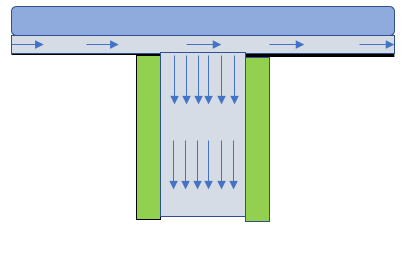

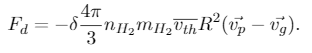

In [71]:
def gravity_force(radius:float):
    """
    Calculates the gravity force, again we assume spherical particles with the previously defined density. The reticle is 
    placed upside down so gravity will point away from it.
    """

    particle_mass = 4/3 * np.pi * (radius)**3 * PARTICLE_DENSITY
    
    return np.array([0,0,-9.81 * particle_mass])
    

## Calculation the trajectories:

In [66]:
def calc_total_force(pos: np.array, vel: np.array, charge: float, field_strength, radius):
    """
    Calculates the total force working on a particle based on its position, velocity, charge and radius. 
    """
    total_force = magnetic_field_force(pos, vel, charge, field_strength = field_strength) +\
                  retticle_attraction_force(pos, charge) +\
                  drag_force(pos,vel, radius) + gravity_force(radius)
    
    return total_force

In [67]:
def next_step(pos: np.array, vel: np.array, mass:float, charge:float,field_strength:float,radius:float,\
              timestep:float = TIMESTEP):
    """
    Calculates the next position and velocity of the particle based on its current postion and velocity using the 
    Runga-Kutta methode:https://nl.wikipedia.org/wiki/Runge-Kuttamethode
    This is like an improved version of the euler method in which new particle positions and velocities are calculated based on
    newtons second law: dv = F/m dt, dx = dv * dt
    
    """
    k1_vel = timestep * calc_total_force(pos, vel, charge,field_strength,radius)/mass
    k1_pos = timestep * vel
    
    k2_vel = timestep * calc_total_force(pos + k1_pos/2, vel + k1_vel/2, charge,field_strength,radius)/mass
    k2_pos = timestep * (vel + k1_vel/2)
    
    k3_vel = timestep * calc_total_force(pos + k2_pos/2, vel + k2_vel/2, charge,field_strength,radius)/mass
    k3_pos = timestep * (vel + k2_vel/2)
    
    k4_vel = timestep * calc_total_force(pos + k3_pos, vel + k3_vel, charge,field_strength,radius)/mass
    k4_pos = timestep * (vel + k3_vel)
    
    new_pos = pos + 1/6*(k1_pos + 2* k2_pos + 2*k3_pos +k4_pos)
    new_vel = vel + 1/6*(k1_vel + 2* k2_vel + 2*k3_vel +k4_vel)
    
    return new_pos, new_vel

In [72]:
def calc_trajectory(vel, charge: float , mass: float, field_strength:float, radius:float, save: bool = False):
    """
    This function can be created to calculate the trajectory for 1 particle in the force fields specified above.
    Particles alway start at origin and the initial velocity, mass and charge need to be specified.
    
    The particle's trajectory is calculated as follows:
    every TIMESTEP the forces on the particle are calculated. Using newtons second law this is translated into a new 
    velocity and new position after the timestep. Then for the new velocity and position it is all repeated again.
    
    The programm is then finished when the particle has reached z= Z_RETICLE (the reticle) or after 1e4 iterations 
    (to prevent from getting stuck in a loop) 
    
    if save, the entire trajectory is returned, otherwise only the final position
    """
    # The starting position for all particles in the simulation:
    pos = np.array([0.,0.,0.]) 
    list_x_pos = [pos[0]]
    list_y_pos = [pos[1]]
    list_z_pos = [pos[2]]
    
    number_of_iterations = 0  
    
    # calculating every step until hit reticle or far away retticle or "stuck" in a loop
    still_inside = True
    while still_inside and number_of_iterations <1e4: 
        
        # calc next velocity and pos according to runga kutta method
        new_pos, new_vel =next_step(pos, vel, mass, charge, field_strength, radius)
        pos, vel = new_pos, new_vel
        
        if save:
            list_x_pos.append(pos[0])
            list_y_pos.append(pos[1])
            list_z_pos.append(pos[2])
            
        number_of_iterations += 1
        
        # check if still close to reticle and not yet hit reticle (all max 1m away)
        if RETICLE_Z - 0.4 < pos[2] < RETICLE_Z and -1 < pos[0] < 1 and -1 < pos[1] < 1 :
            still_inside = True   
        else:
            still_inside = False  
        
    
    # if save also get additional info
    if save:
        print(f"Number of iterations needed: {number_of_iterations}")
        print(f"Velocity at the end: {vel}")
        
    # if run out of iterations or clearly did not hit reticle, set color to green else to red
    # important for final cell of code, for now just ignore
    if number_of_iterations >= 1e4 or (still_inside == False and pos[2]< RETICLE_Z-0.01):
        never_hit = 'green'
    else:
        never_hit = 'blue'
    
    # if save, return the entire trajectory, otherwise just the final position 
    return (list_x_pos, list_y_pos, list_z_pos , pos) if save else (pos, never_hit)

## Plotting the results

In [32]:
def setup_figures():
    """
    This function can just be called to initialize the figures (correct spacing, titles, axes etc.).
    It will return the 3D axis, the 2D axis and the 2D figure in that order.
    
    """
    #Initializing the 3d Figure
    ax_3D = plt.axes(projection = '3d')
    ax_3D.set_xlabel("Y (m)")
    ax_3D.set_ylabel("X (m)")
    ax_3D.set_zlabel("Z (m)")
    
    
    #Initialzing the 2D figure
    fig_2D, ax_2D = plt.subplots(nrows = 1, ncols = 3, figsize = (10,4), constrained_layout=True, squeeze = False)
    fig_2D.suptitle('2D projection of the 3D trajectory', fontsize=16, weight = "bold")

    ax_2D[0,0].set_title("xz-plane")
    ax_2D[0,0].set_xlabel("y(m)")
    ax_2D[0,0].set_ylabel("z(m)")

    ax_2D[0,1].set_title("yz-plane")

    ax_2D[0,2].set_title("xy-plane")
    ax_2D[0,2].set_xlabel("x(m)")
    ax_2D[0,2].set_ylabel("y(m)")
    
    return ax_3D, ax_2D, fig_2D
    

### plotting one trajectory
In this plot, particles start at the beginning of the magnets. One can define particle properties at the beginning.

The cell below compares the trajectory to a trajectory if the B-field is not present. This can be uncommented if not preffered.

In [13]:
#some parameters for just this run, one can change to see how the result changes
radius = 200e-9
initial_velocity = np.array([0, 0, 10])
B_strength = 1.5

particle_mass = calc_mass(radius)
particle_charge = calc_charge(radius)


print("Starting trajectory calculation....")
list_x_pos, list_y_pos, list_z_pos , final_pos = calc_trajectory(initial_velocity, particle_charge, particle_mass, B_strength,
                                                                 radius, save = True)
# also calculate if B-field =0 for comparison 
list_x_pos2, list_y_pos2, list_z_pos2 , final_pos2 = calc_trajectory(initial_velocity, particle_charge, particle_mass, 0,
                                                                 radius, save = True)

print("Finished, starting plot....")

#initializing figures:
ax_3D, ax_2D, fig_2D = setup_figures()

# Plotting the results in 3d axis
ax_3D.scatter([0],[0],[0], marker = "o", s=100, color = "red") # the starting point 
ax_3D.plot3D(list_x_pos,list_y_pos,list_z_pos)                      # the trajectory 
ax_3D.plot3D(list_x_pos2,list_y_pos2,list_z_pos2)  

ax_3D.legend(["With magnet", "Without magnet"])

#plotting result in 2d axes.
ax_2D[0,0].plot(list_x_pos,list_z_pos)
ax_2D[0,1].plot(list_y_pos,list_z_pos)
ax_2D[0,2].plot(list_x_pos,list_y_pos)

ax_2D[0,0].plot(list_x_pos2,list_z_pos2)
ax_2D[0,1].plot(list_y_pos2,list_z_pos2)
ax_2D[0,2].plot(list_x_pos2,list_y_pos2)

ax_2D[0,0].scatter(0,0,c="red")
ax_2D[0,0].legend(["With magnet", "Without magnet"])


print("Done")

Starting trajectory calculation....
Number of iterations needed: 348
Velocity at the end: [ 0.88663324  0.         12.20089624]
Number of iterations needed: 348
Velocity at the end: [ 0.6928671   0.         12.13542121]
Finished, starting plot....
Done


### plotting a few trajectories

Using the cell below, it is possible to plot the particle velocities for a range of particle properties by simply changing a few things. (You'll figure it out yourself if you carefully read through it)

In [73]:
#some parameters for just this run, one can change to see how the result changes
radius = 50e-9
initial_velocity = np.array([0, 0, 10])
B_strength = 1.5

particle_mass = calc_mass(radius)
particle_charge = calc_charge(radius)

#initializing figures:
ax_3D, ax_2D, fig_2D = setup_figures()
ax_3D.scatter([0],[0],[0], marker = "o", s=100, color = "red") # the starting point 

#just create a list with all the quantities you want to measure, don't forget to also update legend!
particle_r_list = [25e-9, 50e-9, 100e-9, 200e-9, 500e-9, 5000e-9]

#in this run as an example I changed the initial velocity, changes this to the desired quantity
for radius in particle_r_list:
    print("\n",f"Starting trajectory calcluation next particle with value {radius}")
    
    #update the quantity(-ies) 
    particle_mass = calc_mass(radius)
    particle_charge = calc_charge(radius)
    
    #again calc everything trajectory
    list_x_pos, list_y_pos, list_z_pos , final_pos = calc_trajectory(initial_velocity, particle_charge, particle_mass,
                                                                     B_strength,radius, save = True)

    # updating plots
    ax_3D.plot3D(list_x_pos,list_y_pos,list_z_pos)  
    ax_2D[0,0].plot(list_x_pos,list_z_pos)
    ax_2D[0,1].plot(list_y_pos,list_z_pos)
    ax_2D[0,2].plot(list_x_pos,list_y_pos)
    
    
print("\n","Done")

ax_3D.legend(particle_r_list)
ax_2D[0,0].legend(particle_r_list)

# # If we want to make it rotate (for a video):
# for angle in range(0, 360):
#     ax_3D.view_init(30, angle)
#     plt.draw()
#     plt.pause(.001)


 Starting trajectory calcluation next particle with value 2.5e-08
Number of iterations needed: 10000
Velocity at the end: [ 0.67693936  0.         -0.81684453]

 Starting trajectory calcluation next particle with value 5e-08
Number of iterations needed: 10000
Velocity at the end: [1.68955518 0.         2.43608602]

 Starting trajectory calcluation next particle with value 1e-07
Number of iterations needed: 7833
Velocity at the end: [ 2.39606529  0.         15.88331164]

 Starting trajectory calcluation next particle with value 2e-07
Number of iterations needed: 6947
Velocity at the end: [ 0.89091551  0.         10.58936532]

 Starting trajectory calcluation next particle with value 5e-07
Number of iterations needed: 6538
Velocity at the end: [0.2832244  0.         9.43150581]

 Starting trajectory calcluation next particle with value 5e-06
Number of iterations needed: 6321
Velocity at the end: [0.02380279 0.         9.62427657]

 Done


### plotting all of the final distances depending on some properties
One needs to set the timestep to a smaller number to get reliable reliable results here, but then it will take longer to run the cell.

As the cell is right now, it will plot the final distances depending on the particle radius.

In [46]:
#some parameters for just this run, one can change to see how the result changes
radius = 50e-9
initial_velocity = np.array([0, 0, 10])
B_strength = 0

#just create a list with all the quantities you want to measure
particle_r_list = list(range(5,100,10))+ list(range(100,1000, 25))

# a list to hold the colors of dots to make clear if hit reticle or not
color_list = []

#a dictionary to hold all of the distances
distances = {}

for radius in particle_r_list:
    radius = radius * 10**-9
    
    #update the quantity(-ies) 
    particle_mass = calc_mass(radius)
    particle_charge = calc_charge(radius)
        
    final_pos, never_hit = calc_trajectory(initial_velocity,particle_charge, particle_mass,B_strength,radius, save = False)
    
    color_list.append(never_hit)
    #if doesn't hit final position doesn't matter so don't calc distance
    if never_hit == 'green':
        distance = 0
    else:
        # calc distance to centre reticle at (0,0,RETICLE_Z):
        reticle_center = np.array([0,0, RETICLE_Z]) 
        distance = np.linalg.norm(final_pos - reticle_center)
        
    distances[radius] = distance

    
print(f"dic of distances: {distances}")

#create the plot. Particles never hitting the reticle are colored green. Others are all colored blue.
plt.scatter(list(distances.keys()),list(distances.values()), c=color_list)
plt.xlabel("Particle radius (m)")
plt.ylabel("Horizontal displacement (m)")

print("Done")

dic of distances: {5e-09: 0, 1.5000000000000002e-08: 0, 2.5000000000000002e-08: 0, 3.5e-08: 0, 4.5000000000000006e-08: 0.023205700188018593, 5.5e-08: 0.006819201350525463, 6.5e-08: 0.003718937102758775, 7.500000000000001e-08: 0.002497299028731807, 8.500000000000001e-08: 0.0018332900091455205, 9.5e-08: 0.001459543724492834, 1.0000000000000001e-07: 0.0013171971737201461, 1.2500000000000002e-07: 0.0008786946264870476, 1.5000000000000002e-07: 0.0006662881814081921, 1.7500000000000002e-07: 0.0005256167064855793, 2.0000000000000002e-07: 0.0004338188318258759, 2.2500000000000002e-07: 0.0003745231832372794, 2.5000000000000004e-07: 0.00033789652066620955, 2.75e-07: 0.00028438830226812893, 3.0000000000000004e-07: 0.0002656469444048101, 3.25e-07: 0.0002472271171715418, 3.5000000000000004e-07: 0.0002150469248222437, 3.75e-07: 0.00021099292184086136, 4.0000000000000003e-07: 0.00019198977365799178, 4.25e-07: 0.0001669877737636758, 4.5000000000000003e-07: 0.0001627054537440388, 4.75e-07: 0.0001695443

## plotting the efficiency in the particle deflection by adding a magnet w.r.t no magnet
Similary, also here the timestep should be set much smaller for reliable results, which will again result in much larger computation times.

In [68]:
# All particles start at the same velocity
initial_velocity = np.array([0, 0, 10])


#all of the radiuses we want to check still convert to nm
particle_r_list = list(range(5,100,10))+ list(range(100,1000, 25))

# a list to hold the colors of dots to make clear if hit reticle or not
color_list = []

#a dictionary to hold all of the efficiencies
dictionary_eff = {}

for radius in particle_r_list:
    radius = radius*1e-9
    
    
    #update the quantity(-ies) 
    particle_mass = calc_mass(radius)
    particle_charge = calc_charge(radius)
        
    # simulate trajectory and calc final pos with and without magnet
    final_pos, never_hit = calc_trajectory(initial_velocity,particle_charge, particle_mass,1.5,radius, save = False)
    final_pos_no, never_hit_no = calc_trajectory(initial_velocity,particle_charge, particle_mass,0,radius, save = False)
    
    #if in both cases never hit reticle, color green and set efficiency to 0 (calc don't matter)
    if never_hit == "green" and never_hit_no == "green":
        efficiency = 0
        color_list.append("green")
    # if only now by adding a magnet no reticle hit, color cyan:
    elif never_hit == "green" and never_hit_no == "blue":
        efficiency = 0
        color_list.append("cyan")
    else:
        # calc distance to reticle centre for both cases:
        reticle_center = np.array([0,0, RETICLE_Z]) 
        distance = np.linalg.norm(final_pos - reticle_center)
        distance_no = np.linalg.norm(final_pos_no - reticle_center)
        
        #calc improvement in %:
        efficiency = (distance/distance_no-1)*100
        
        color_list.append("blue")
        
    dictionary_eff[radius] = efficiency

    
print(f"dic of distances: {dictionary_eff}")

#create the plot. Particles never hitting the reticle are colored green. Others are all colored blue.
plt.scatter(list(dictionary_eff.keys()),list(dictionary_eff.values()), c=color_list)
plt.xlabel("Particle radius (m)")
plt.ylabel("Distance increase %")
plt.title("Final distances increase as function of particle radius")

print("Done")

dic of distances: {5e-09: 0, 1.5000000000000002e-08: 0, 2.5000000000000002e-08: 0, 3.5e-08: 0, 4.5000000000000006e-08: 0, 5.5e-08: 0, 6.5e-08: 1179.9415609530208, 7.500000000000001e-08: 1247.50581208396, 8.500000000000001e-08: 1266.9458958484047, 9.5e-08: 1244.954608755997, 1.0000000000000001e-07: 1233.5256344894653, 1.2500000000000002e-07: 1141.7634902081961, 1.5000000000000002e-07: 1039.1554796600683, 1.7500000000000002e-07: 945.9456544251225, 2.0000000000000002e-07: 865.9013513821599, 2.2500000000000002e-07: 783.0153434947562, 2.5000000000000004e-07: 724.2083483721526, 2.75e-07: 685.0058916680124, 3.0000000000000004e-07: 637.4279814293704, 3.25e-07: 591.5203555076125, 3.5000000000000004e-07: 551.5382619403034, 3.75e-07: 522.9223070747855, 4.0000000000000003e-07: 502.16566902020696, 4.25e-07: 477.92012204453636, 4.5000000000000003e-07: 436.8868937766362, 4.75e-07: 420.71347419141773, 5.000000000000001e-07: 387.0925174625702, 5.250000000000001e-07: 370.7660636710058, 5.5e-07: 361.5811